# Image Classification - Deep Learning

This notebook demonstrates training multiple models (RegNetY-032, ViT-Base, CSPDarkNet53) on the Oxford-IIIT Pet dataset with evaluation and export workflows.

## 1. Environment Setup
Install dependencies (choose matching CUDA wheel if needed).

In [ ]:
!git clone https://github.com/HenryNVP/image-classification.git
%cd image-classification

In [ ]:
!pip install -r requirements.txt

## 2. Download and Prepare Data
This downloads the official dataset and prepares 256x256 splits.

In [ ]:
!python scripts/get_data.py
!python scripts/split_dataset.py

## 3. Train Multiple Models
Train RegNetY-032, ViT-Base, and CSPDarkNet53 sequentially.

In [ ]:
# Define models to train
models = [
    ('regnety_032', 'configs/model/regnety_032.yaml'),
    ('vit_base_patch16_224', 'configs/model/vit_base_patch16_224.yaml'),
    ('cspdarknet53', 'configs/model/cspdarknet53.yaml')
]

# Train each model
for model_name, model_config in models:
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}\n")
    !python train.py --model-config {model_config} --output-dir checkpoints/{model_name} --plot
    print(f"\nCompleted training {model_name}")

## 4. Evaluate All Models
Test all trained models on the test split and compare results.

In [ ]:
# Evaluate each model on test set
results = {}

for model_name, model_config in models:
    print(f"\n{'='*60}")
    print(f"Evaluating {model_name}")
    print(f"{'='*60}\n")
    !python validate.py --model-config {model_config} --checkpoint checkpoints/{model_name}/best.pth --split test --output checkpoints/{model_name}/test_metrics.json
    
print(f"\n{'='*60}")
print("Summary of Test Results")
print(f"{'='*60}\n")

# Display results summary
import json
from pathlib import Path

for model_name, _ in models:
    metrics_path = Path(f'checkpoints/{model_name}/test_metrics.json')
    if metrics_path.exists():
        with open(metrics_path) as f:
            metrics = json.load(f)
        print(f"{model_name:30s} - Accuracy: {metrics.get('accuracy', 0)*100:.2f}% | Loss: {metrics.get('loss', 0):.4f}")
    else:
        print(f"{model_name:30s} - Metrics not found")

## 5. Compare Predictions Across Models
Visualize predictions from all three models on the same sample.

Sample index: 1246
Ground truth label: 25 (leonberger)
Top-5 probabilities: torch.return_types.topk(
values=tensor([0.6062, 0.0365, 0.0251, 0.0244, 0.0204], device='cuda:0'),
indices=tensor([25, 17, 32, 10,  8], device='cuda:0'))
Top prediction: 25 (leonberger)


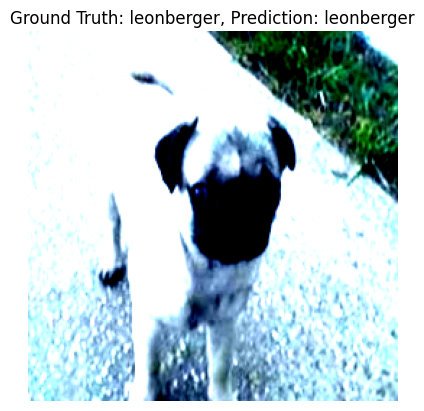

In [ ]:
import torch
from pathlib import Path
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

from src.config import load_configs, to_namespace
from src.data import ImageClassificationDataset
from src.models import create_model
from src.utils import get_device

device = torch.device(get_device())

# Load dataset
dataset = ImageClassificationDataset('data/val', 'data/val_labels.csv', train=False)
class_names = dataset.classes

# Pick a random sample
idx = torch.randint(0, len(dataset), ()).item()
image, label = dataset[idx]

# Load all three models
loaded_models = {}
for model_name, model_config in models:
    cfg_paths = [
        Path('configs/train.yaml'),
        Path('configs/data.yaml'),
        Path(model_config),
        Path('configs/aug.yaml'),
    ]
    config = load_configs(cfg_paths)
    model_cfg = to_namespace(config['model'])
    
    model = create_model(model_cfg)
    checkpoint_path = f'checkpoints/{model_name}/best.pth'
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()
    model.to(device)
    loaded_models[model_name] = model

# Get predictions from all models
print(f'Sample index: {idx}')
print(f'Ground truth: {label} ({class_names[label]})')
print(f'\n{"Model":<30} {"Top Prediction":<25} {"Confidence":<10} {"Correct"}')
print('='*80)

predictions = {}
with torch.no_grad():
    for model_name, model in loaded_models.items():
        logits = model(image.unsqueeze(0).to(device))
        prob = torch.softmax(logits, dim=1).squeeze(0)
        top_idx = prob.topk(1).indices.item()
        top_conf = prob.topk(1).values.item()
        predictions[model_name] = (top_idx, top_conf, prob)
        
        correct = "✓" if top_idx == label else "✗"
        print(f'{model_name:<30} {class_names[top_idx]:<25} {top_conf*100:>6.2f}%    {correct}')

# Visualize the image with all predictions
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Original image
axes[0].imshow(image.permute(1, 2, 0).clamp(0, 1))
axes[0].set_title(f"Ground Truth:\n{class_names[label]}", fontsize=12, fontweight='bold')
axes[0].axis('off')

# Predictions from each model
for idx, (model_name, (pred_idx, conf, prob)) in enumerate(predictions.items(), 1):
    axes[idx].imshow(image.permute(1, 2, 0).clamp(0, 1))
    color = 'green' if pred_idx == label else 'red'
    axes[idx].set_title(f"{model_name}:\n{class_names[pred_idx]} ({conf*100:.1f}%)", 
                        fontsize=12, color=color, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [21]:
!pip install onnx onnxruntime-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 MB 3.5 MB/s eta 0:00:00


In [ ]:
# Export all models to TorchScript and ONNX
for model_name, model_config in models:
    print(f"\n{'='*60}")
    print(f"Exporting {model_name}")
    print(f"{'='*60}\n")
    !python scripts/export_models.py \
      --model-config {model_config} \
      --checkpoint checkpoints/{model_name}/best.pth \
      --output-dir exports/{model_name}
    print(f"\nCompleted exporting {model_name}")


Saved TorchScript model to exports/regnety_016/model_scripted.pt
/content/image-classification/scripts/export_models.py:145: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
Saved ONNX model to exports/regnety_016/model.onnx


In [ ]:
# Test TorchScript inference for all models
import torch

print(f'{"Model":<30} {"Format":<15} {"Prediction":<25} {"Confidence"}')
print('='*90)

# Use the same image and move it to the correct device
image = image.to(device)

for model_name, _ in models:
    scripted_model = torch.jit.load(f'exports/{model_name}/model_scripted.pt')
    scripted_model.eval()
    scripted_model.to(device)
    
    with torch.no_grad():
        scripted_logits = scripted_model(image.unsqueeze(0))
    scripted_prob = torch.softmax(scripted_logits, dim=1).squeeze(0)
    pred_idx = scripted_prob.topk(1).indices.item()
    pred_conf = scripted_prob.topk(1).values.item()
    
    print(f'{model_name:<30} {"TorchScript":<15} {class_names[pred_idx]:<25} {pred_conf*100:>6.2f}%')


TorchScript Top prediction: 25 (leonberger)


In [ ]:
# Test ONNX inference for all models
import onnxruntime
import numpy as np
from torchvision import transforms

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# Resize the image to the expected input size of the ONNX model
resize_transform = transforms.Resize((224, 224))
resized_image = resize_transform(image)

print(f'{"Model":<30} {"Format":<15} {"Prediction":<25} {"Confidence"}')
print('='*90)

for model_name, _ in models:
    ort_session = onnxruntime.InferenceSession(
        f'exports/{model_name}/model.onnx', 
        providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
    )
    
    # ONNX Runtime expects NumPy arrays
    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(resized_image.unsqueeze(0))}
    ort_outputs = ort_session.run(None, ort_inputs)
    
    # The output is a list, get the first element
    onnx_logits = torch.tensor(ort_outputs[0])
    onnx_prob = torch.softmax(onnx_logits, dim=1).squeeze(0)
    pred_idx = onnx_prob.topk(1).indices.item()
    pred_conf = onnx_prob.topk(1).values.item()
    
    print(f'{model_name:<30} {"ONNX":<15} {class_names[pred_idx]:<25} {pred_conf*100:>6.2f}%')

ONNX Runtime Top prediction: 25 (leonberger)


In [ ]:
# Quick benchmark of TorchScript and ONNX for all models
import time

num_runs = 100
benchmark_results = []

for model_name, _ in models:
    print(f"\nBenchmarking {model_name}...")
    
    # Benchmark TorchScript
    scripted_model = torch.jit.load(f'exports/{model_name}/model_scripted.pt')
    scripted_model.eval()
    scripted_model.to(device)
    
    torchscript_start_time = time.time()
    for _ in range(num_runs):
        with torch.no_grad():
            scripted_logits = scripted_model(image.unsqueeze(0))
    torchscript_end_time = time.time()
    torchscript_avg_time = (torchscript_end_time - torchscript_start_time) / num_runs
    torchscript_fps = 1 / torchscript_avg_time
    
    # Benchmark ONNX
    ort_session = onnxruntime.InferenceSession(
        f'exports/{model_name}/model.onnx', 
        providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
    )
    
    onnx_start_time = time.time()
    for _ in range(num_runs):
        ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(resized_image.unsqueeze(0))}
        ort_outputs = ort_session.run(None, ort_inputs)
    onnx_end_time = time.time()
    onnx_avg_time = (onnx_end_time - onnx_start_time) / num_runs
    onnx_fps = 1 / onnx_avg_time
    
    benchmark_results.append({
        'model': model_name,
        'torchscript_fps': torchscript_fps,
        'torchscript_ms': torchscript_avg_time * 1000,
        'onnx_fps': onnx_fps,
        'onnx_ms': onnx_avg_time * 1000
    })

# Display benchmark results
print(f"\n{'='*100}")
print("Benchmark Results Summary")
print(f"{'='*100}")
print(f"{'Model':<30} {'TorchScript FPS':<20} {'TorchScript Latency':<20} {'ONNX FPS':<15} {'ONNX Latency'}")
print('-'*100)
for result in benchmark_results:
    print(f"{result['model']:<30} {result['torchscript_fps']:>15.2f} {result['torchscript_ms']:>18.2f} ms {result['onnx_fps']:>14.2f} {result['onnx_ms']:>13.2f} ms")

TorchScript Model:
  Average inference time: 0.025746 seconds
  Estimated FPS: 38.84
  Estimated delay: 25.75 ms
--------------------
ONNX Runtime Model:
  Average inference time: 0.005026 seconds
  Estimated FPS: 198.95
  Estimated delay: 5.03 ms


In [ ]:
# Run comprehensive benchmark script for all models
for model_name, model_config in models:
    print(f"\n{'='*60}")
    print(f"Comprehensive Benchmark: {model_name}")
    print(f"{'='*60}\n")
    !python scripts/benchmark_models.py \
      --model-config {model_config} \
      --checkpoint checkpoints/{model_name}/best.pth \
      --torchscript exports/{model_name}/model_scripted.pt \
      --onnx exports/{model_name}/model.onnx \
      --device cuda --warmup 10 --runs 100 --batch-size 1


--- Benchmark Results ---
pytorch: FPS=59.76 Latency=16.73ms Total=1.673s
torchscript: FPS=103.82 Latency=9.63ms Total=0.963s
onnx: FPS=228.56 Latency=4.38ms Total=0.438s


## 6. Final Summary and Comparison

Compare all models across metrics, inference formats, and performance.


In [ ]:
# Comprehensive comparison of all models
import json
from pathlib import Path
import pandas as pd

# Collect all metrics
comparison_data = []

for model_name, _ in models:
    row = {'Model': model_name}
    
    # Test metrics
    test_metrics_path = Path(f'checkpoints/{model_name}/test_metrics.json')
    if test_metrics_path.exists():
        with open(test_metrics_path) as f:
            test_metrics = json.load(f)
        row['Test Accuracy (%)'] = test_metrics.get('accuracy', 0) * 100
        row['Test Loss'] = test_metrics.get('loss', 0)
    
    # Training history (validation accuracy)
    history_path = Path(f'checkpoints/{model_name}/history.json')
    if history_path.exists():
        with open(history_path) as f:
            history = json.load(f)
        if history:
            best_val_acc = max([entry.get('val_acc', 0) for entry in history])
            row['Best Val Accuracy (%)'] = best_val_acc * 100
            row['Epochs Trained'] = len(history)
    
    # Benchmark results (if available from the quick benchmark)
    benchmark_result = next((b for b in benchmark_results if b['model'] == model_name), None)
    if benchmark_result:
        row['TorchScript FPS'] = benchmark_result['torchscript_fps']
        row['ONNX FPS'] = benchmark_result['onnx_fps']
        row['TorchScript Latency (ms)'] = benchmark_result['torchscript_ms']
        row['ONNX Latency (ms)'] = benchmark_result['onnx_ms']
    
    comparison_data.append(row)

# Create DataFrame for nice display
df = pd.DataFrame(comparison_data)
print("\n" + "="*120)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*120 + "\n")
display(df)

# Highlight best performers
print("\n" + "="*120)
print("BEST PERFORMERS")
print("="*120)
if 'Test Accuracy (%)' in df.columns:
    best_accuracy_model = df.loc[df['Test Accuracy (%)'].idxmax(), 'Model']
    best_accuracy = df['Test Accuracy (%)'].max()
    print(f"🏆 Best Accuracy: {best_accuracy_model} ({best_accuracy:.2f}%)")

if 'ONNX FPS' in df.columns:
    fastest_model = df.loc[df['ONNX FPS'].idxmax(), 'Model']
    fastest_fps = df['ONNX FPS'].max()
    print(f"⚡ Fastest Inference (ONNX): {fastest_model} ({fastest_fps:.2f} FPS)")

if 'ONNX Latency (ms)' in df.columns:
    lowest_latency_model = df.loc[df['ONNX Latency (ms)'].idxmin(), 'Model']
    lowest_latency = df['ONNX Latency (ms)'].min()
    print(f"⏱️  Lowest Latency (ONNX): {lowest_latency_model} ({lowest_latency:.2f} ms)")

print("\n" + "="*120)
